<a href="https://colab.research.google.com/github/pande17827/LangGraph/blob/main/3.Reflection%20Agent/2.Reflection%20Agent%20-%20Creating%20Chains%20and%20Building%20the%20graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

# <b> Setting LLM

In [1]:
!nvidia-smi

Wed May 28 16:08:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Download and install ollama to the system
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [3]:
!pip install -qq pyngrok ollama

In [4]:
import IPython
import subprocess
from pyngrok import ngrok
from typing import Any, Dict, List, Optional

In [5]:
from google.colab import userdata

def start_ollama_server() -> None:
    """Starts the Ollama server."""
    subprocess.Popen(['ollama', 'serve'])
    print("Ollama server started.")


def check_ollama_port(port: str) -> None:
    """Check if Ollama server is running at the specified port."""
    try:
        subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], check=True, capture_output=True, text=True)
        if any(f":{port} (LISTEN)" in line for line in subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], capture_output=True, text=True).stdout.splitlines()):
            print(f"Ollama is listening on port {port}")
        else:
            print(f"Ollama does not appear to be listening on port {port}.")
    except subprocess.CalledProcessError as e:
         print(f"Error checking Ollama port: {e}")


def setup_ngrok_tunnel(port: str) -> ngrok.NgrokTunnel:
    """Sets up an ngrok tunnel.

    Args:
        port: The port to tunnel.

    Returns:
        The ngrok tunnel object.

    Raises:
        RuntimeError: If the ngrok authtoken is not set.
    """
    ngrok_auth_token = userdata.get('NGROK_AUTHTOKEN')
    if not ngrok_auth_token:
        raise RuntimeError("NGROK_AUTHTOKEN is not set.")

    ngrok.set_auth_token(ngrok_auth_token)
    tunnel = ngrok.connect(port, host_header=f'localhost:{port}')
    print(f"ngrok tunnel created: {tunnel.public_url}")
    return tunnel

In [6]:
NGROK_PORT = '11434'

In [7]:
start_ollama_server()

check_ollama_port(NGROK_PORT)

Ollama server started.
Ollama is listening on port 11434


In [8]:
ngrok_tunnel = setup_ngrok_tunnel(NGROK_PORT)

ngrok tunnel created: https://7db0-34-143-218-108.ngrok-free.app


In [9]:
MODEL_ID = 'gemma3:4b'
PROMPT = 'Why is the sky blue?'

In [10]:
import ollama

In [11]:
def query_ollama_with_client(prompt: str, model_id: str, img_path: list = None) -> None:
    """Queries the Ollama server using the `ollama-python` client library.

    Args:
        prompt: The prompt to send to the model.
        model_id: The ID of the model to use.
    """
    try:
        messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ]

        if img_path:
          messages[0]['images'] = [img_path]

        response = client.chat(
            model=model_id,
            messages=messages
        )
        print("Response from ollama client:")
        print(response['message']['content'])
    except Exception as e:
        print(f"Error querying Ollama with client: {e}")

In [12]:
# Setup an Ollama client with the provided host
client = ollama.Client(host=ngrok_tunnel.public_url)

In [13]:
!pip install langchain
!pip install langchain_community
!pip install langchain_ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00


In [14]:
MODEL_ID="qwen3:8b"
# Load the model at the client
client.pull(model=MODEL_ID)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [15]:
from langchain_ollama.chat_models import ChatOllama
# Initialize the Ollama model with your ngrok public URL
llm = ChatOllama(
    base_url=ngrok_tunnel.public_url,
    model=MODEL_ID
)




In [16]:
llm.invoke("what is the capital of India")

AIMessage(content='<think>\nOkay, the user is asking for the capital of India. I need to make sure I provide the correct answer. Let me recall... India is a country in South Asia. The capital is a well-known fact, but I should verify to avoid mistakes. I remember that New Delhi is the capital. Wait, but sometimes people might confuse it with Delhi. Let me think. Yes, New Delhi is the capital, while Delhi is the name of the city where the capital is located. So the answer should be New Delhi. I should also mention that Delhi is the city where the capital is situated. That way, the user gets the full context. Let me double-check. Yes, New Delhi is the correct capital. No need to complicate it further. Just state it clearly.\n</think>\n\nThe capital of India is **New Delhi**. It is a city located in the northern part of the country and serves as the political, cultural, and administrative center of India. While "Delhi" is often used colloquially to refer to the city, the official capital 

# <b>Step1:-creating Chains

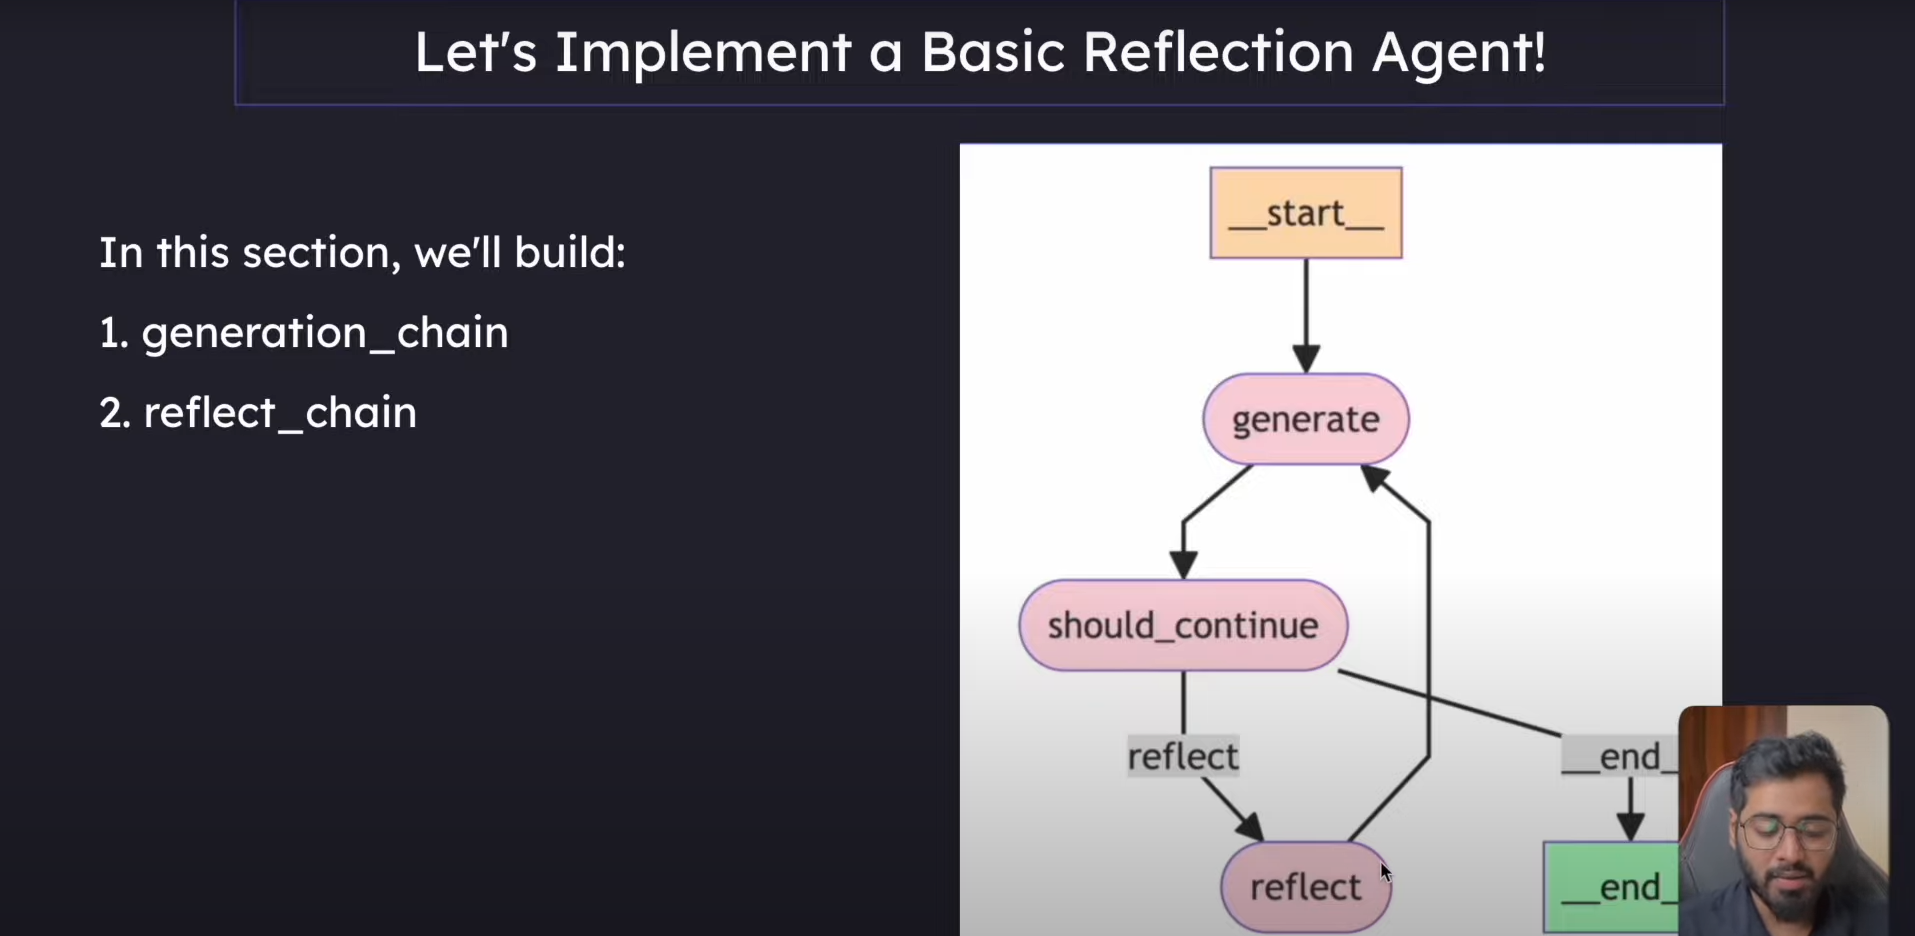

In [17]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
            " Generate the best twitter post possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet."
            " Always provide detailed recommendations, including requests for length, virality, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


generation_chain=generation_prompt | llm
reflection_chain=reflection_prompt | llm


# <b>step2:-Building the Graph

In [2]:
pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 23.5 MB/s eta 0:00:00


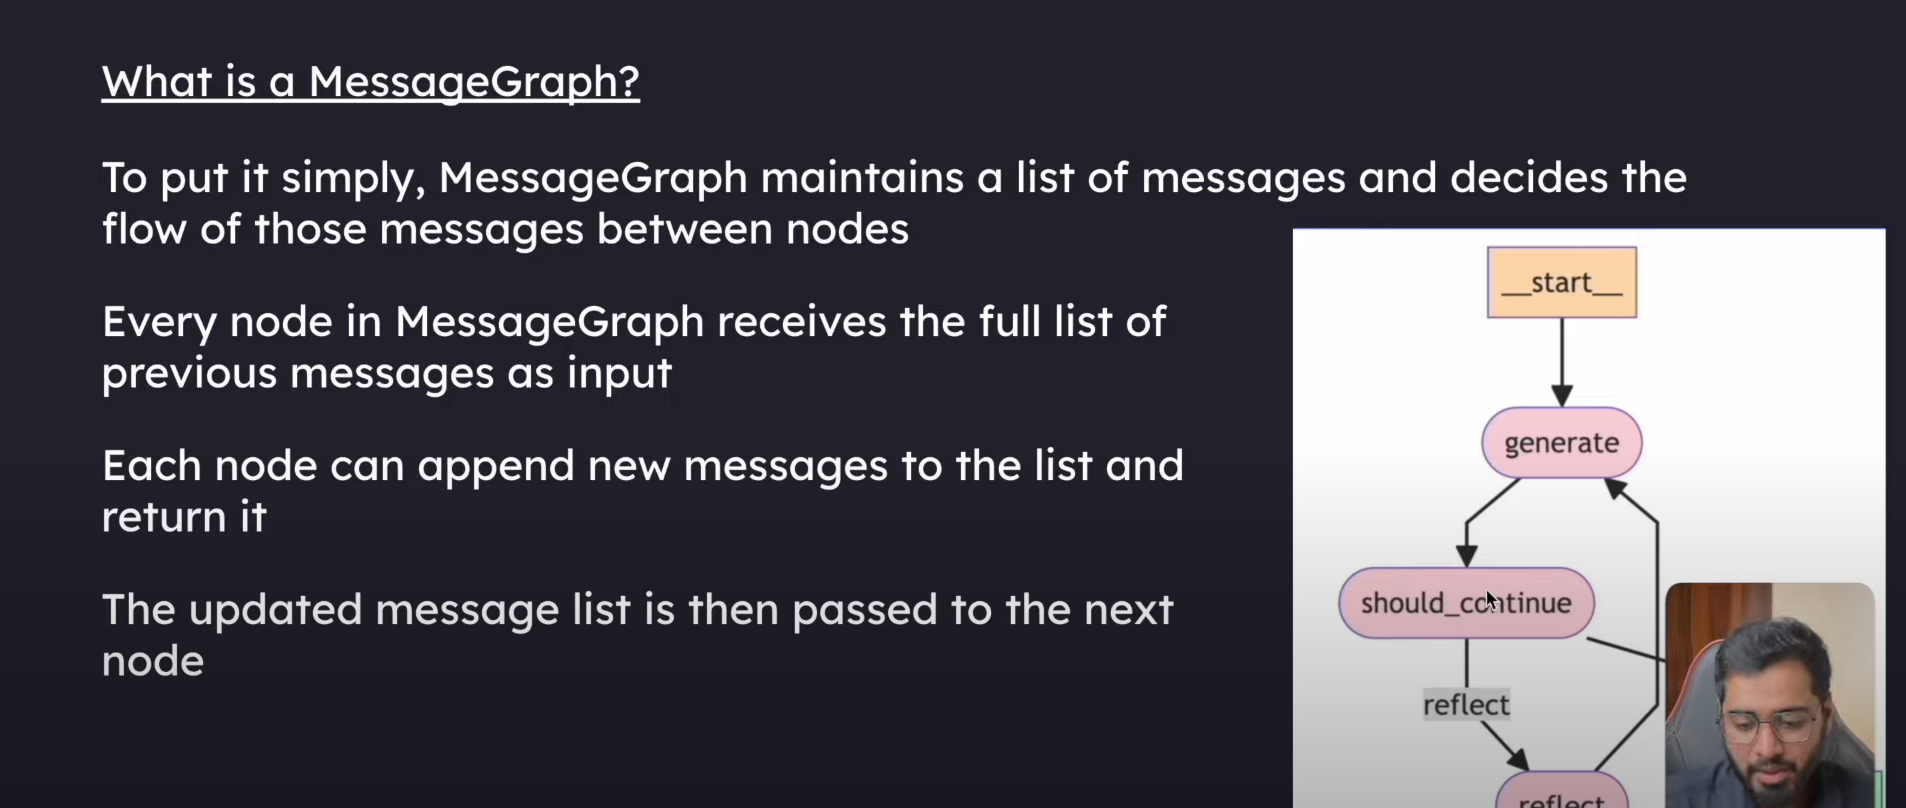

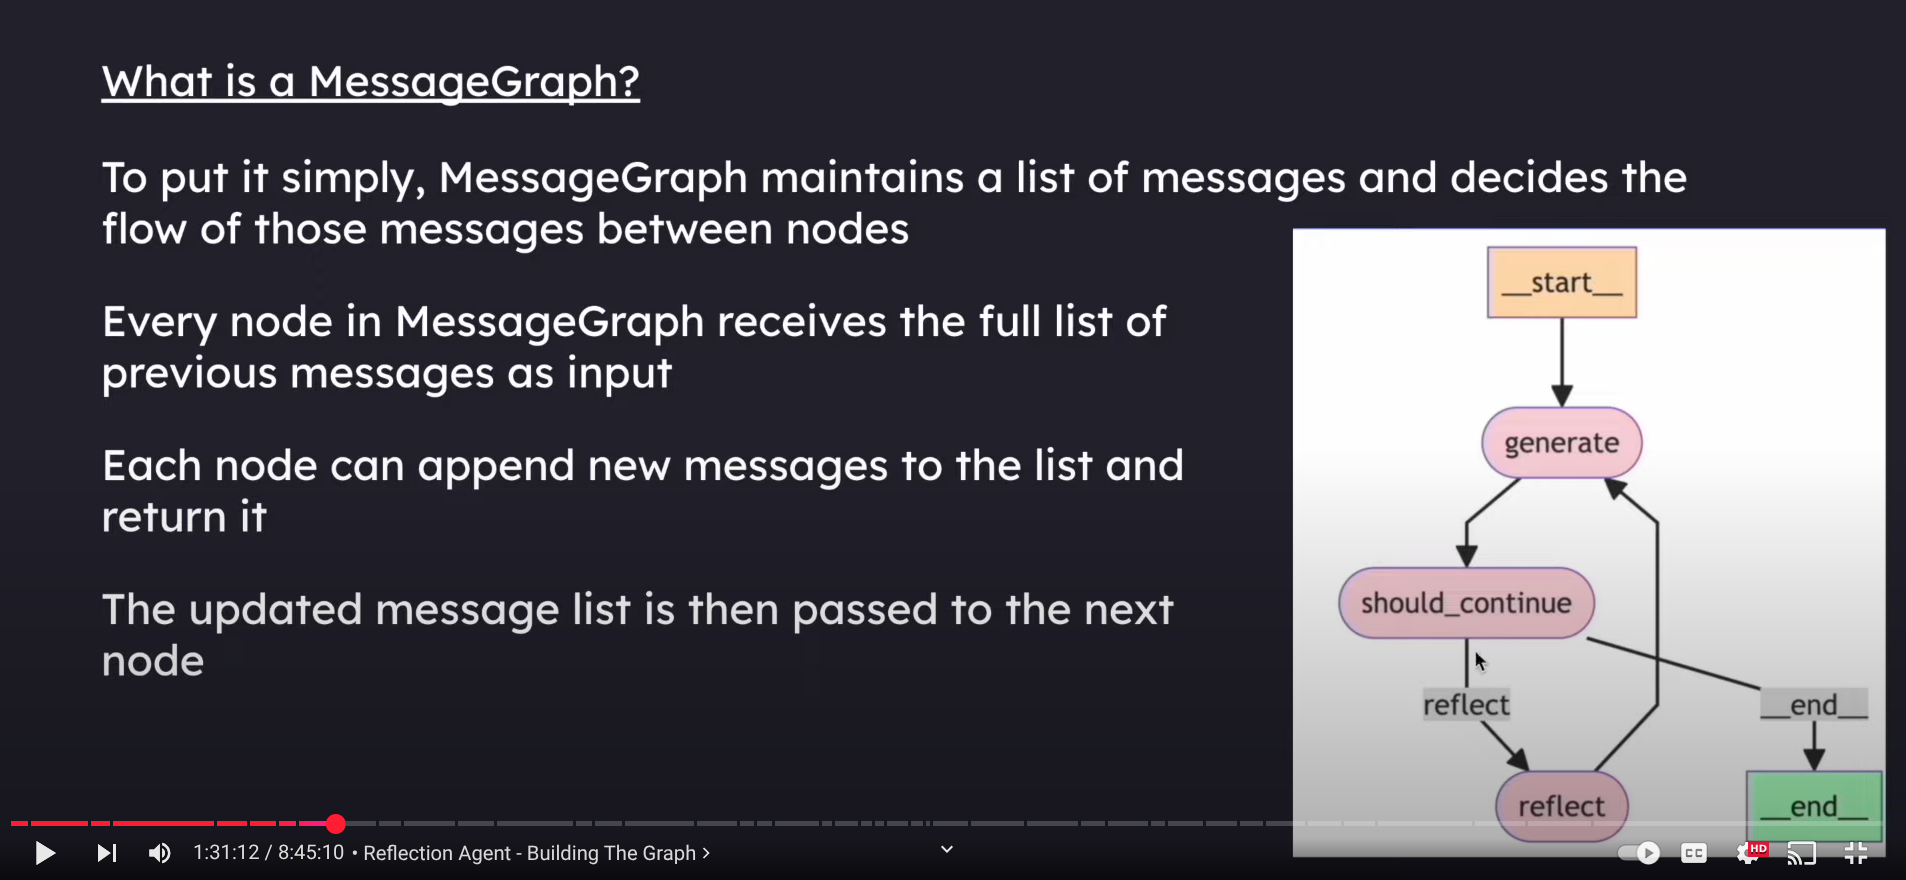

In [3]:
pip install grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.9 MB/s eta 0:00:00


In [4]:
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph

graph=MessageGraph()

REFLECT="reflect"
GENERATE="generate"

# creating node
def generate_node(state):
  return generation_chain.invoke({'messages':state})

def reflect_node(state):
  response=reflection_chain.invoke({'messages':state})
  return [HumanMessage(content=response.content)]

graph.add_node(GENERATE,generate_node)
graph.add_node(REFLECT,reflect_node)

graph.set_entry_point(GENERATE)

def should_continue(state):
  if (len(state)>4):
    return END
  else:
    return REFLECT
graph.add_conditional_edges(GENERATE,should_continue)
graph.add_edge(REFLECT,GENERATE)

app=graph.compile()

print(app.get_graph().draw_mermaid())
app.get_graph().print_ascii()

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	generate(generate)
	reflect(reflect)
	__end__(<p>__end__</p>)
	__start__ --> generate;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
+----------+   
| generate |   
+----------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   
